# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)

def scale_x_encode_y(x, y):

    x_scaled = normalize(x.values)
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
df = pd.read_csv('data/tab_tick_2019.csv')
df.head(5)

,tick_avg,spread_avg,tick_sd,sema,lema,sema_diff,lema_diff,diff,avg_gain,avg_loss,...,ssma_diff,lsma,lsma_diff,sma_diff,max_tick,min_tick,max_gap,min_gap,ema_diff,direction
0,1.146322,0.000234,0.000011,1.146323,1.146355,1.063391e-06,-3.599718e-07,-0.000009,0.000007,0.000010,...,0.000003,1.146357,-0.000002,-0.000046,1.146361,1.146198,0.000039,-0.000124,-0.000033,same
1,1.146271,0.000306,0.000015,1.146319,1.146357,-3.848168e-06,1.376940e-06,-0.000051,0.000007,0.000011,...,0.000004,1.146353,-0.000005,-0.000037,1.146361,1.146224,0.000090,-0.000047,-0.000038,same
2,1.146260,0.000335,0.000007,1.146314,1.146360,-5.083489e-06,3.357754e-06,-0.000011,0.000007,0.000012,...,0.000002,1.146350,-0.000003,-0.000033,1.146361,1.146228,0.000101,-0.000032,-0.000046,same
3,1.146310,0.000254,0.000028,1.146315,1.146358,8.506514e-07,-1.952792e-06,0.000050,0.000010,0.000012,...,0.000004,1.146342,-0.000008,-0.000021,1.146361,1.146260,0.000052,-0.000050,-0.000043,same
4,1.146294,0.000307,0.000028,1.146312,1.146352,-2.520140e-06,-5.857545e-06,-0.000015,0.000010,0.000009,...,-0.000002,1.146334,-0.000008,-0.000015,1.146361,1.146260,0.000067,-0.000035,-0.000040,same


In [5]:
target_col = 'direction'
#x_scaled, y_encoded, y_map, scaler_obj = data_prep(df)
x = df.loc[:, df.columns != target_col]
y = df[target_col]
x_scaled, y_encoded, y_map = scale_x_encode_y(x, y)
#joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

['data/model/y_map.pkl']

## Neural Network

### Network building

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [7]:
model = Sequential([
    Dense(units = 2048, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 1024, activation='relu'),
    Dropout(0.5),
    Dense(units = 512, activation='relu'),    
    Dense(units = 256, activation='relu'),
    Dense(units = 128, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(
    #loss='categorical_crossentropy', 
    loss='binary_crossentropy',     
    optimizer=Adam(learning_rate=0.0001),    
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              47104     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 3

### Training

In [8]:
epoch_val         = 5
batch_size_val    = 8192

verbose_val       = 1
workers_val       = -1

In [9]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/5
143/143 [==============================] - 6s 43ms/step - loss: 0.4812 - accuracy: 0.6746 - val_loss: 0.3688 - val_accuracy: 0.7413
Epoch 2/5
143/143 [==============================] - 6s 43ms/step - loss: 0.3697 - accuracy: 0.7413 - val_loss: 0.3678 - val_accuracy: 0.7419
Epoch 3/5
143/143 [==============================] - 6s 43ms/step - loss: 0.3688 - accuracy: 0.7421 - val_loss: 0.3678 - val_accuracy: 0.7419
Epoch 4/5
143/143 [==============================] - 6s 43ms/step - loss: 0.3683 - accuracy: 0.7423 - val_loss: 0.3687 - val_accuracy: 0.7407
Epoch 5/5
143/143 [==============================] - 6s 43ms/step - loss: 0.3681 - accuracy: 0.7424 - val_loss: 0.3683 - val_accuracy: 0.7413


### DNN

In [10]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.66      0.56      0.61     51406
    increase       0.66      0.54      0.59     51209
        same       0.78      0.84      0.81    189239

    accuracy                           0.74    291854
   macro avg       0.70      0.65      0.67    291854
weighted avg       0.73      0.74      0.74    291854



In [11]:
model.save('data/model/model.h5') 
model_new = load_model('data/model/model.h5')

### DNN Prediction

              precision    recall  f1-score   support

    decrease       0.82      0.49      0.61    361002
    increase       0.86      0.38      0.53    357378
        same       0.56      0.89      0.69    584009

    accuracy                           0.64   1302389
   macro avg       0.75      0.59      0.61   1302389
weighted avg       0.71      0.64      0.63   1302389



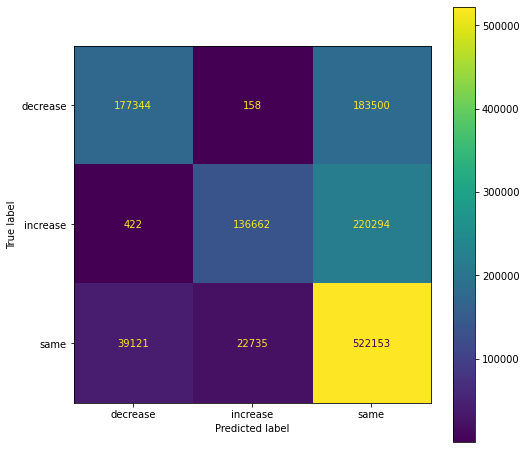

In [13]:
df = pd.read_csv('data/tab_tick_2018.csv')
#x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

x = df.loc[:, df.columns != target_col]
y = df[target_col]
x_scaled1, y_encoded1, y_map1 = scale_x_encode_y(x, y)

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df['predictions'] = [y_map1[k] for k in rounded_predictions]
df.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

In [14]:
live_df = pd.read_csv('data/live_preds.csv')
del live_df['predicted_direction']

model_new = load_model('data/model/model.h5')    
scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 

x_scaled = normalize(live_df.values)
predictions = model_new.predict(x_scaled) 
rounded_predictions = np.argmax(predictions, axis = -1)

#live_df['predictions'] = y_map[data['rounded_predictions'][0]]
live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()

{0: 'decrease', 1: 'increase', 2: 'same'}


increase    283
Name: predictions, dtype: int64

## RF Results

%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)

live_df = pd.read_csv('data/live_preds.csv')
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf.predict(x_scaled)
rounded_predictions = np.argmax(predictions, axis = -1)

#live_df['predictions'] = y_map[data['rounded_predictions'][0]]
live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()